<a href="https://colab.research.google.com/github/MdFoysalBhuiyan/ML/blob/main/ML%20paper%20final%20train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q roboflow timm scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 140.3 MB/s eta 0:00:00


In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="LLmMBNcaTEdLcpGjka0A")
project = rf.workspace("sharjeel-couwf").project("fabric-defect-detection-rfiky-fggaa")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fabric-Defect-detection-1 in folder:: 100%|██████████| 2745/2745 [00:04<00:00, 560.70it/s]


In [ ]:
import os

data_dir = dataset.location
print("Dataset path:", data_dir)
print("Folders:", os.listdir(data_dir))


Dataset path: /content/Fabric-Defect-detection-1
Folders: ['README.dataset.txt', 'test', 'valid', 'README.roboflow.txt', 'train']


In [ ]:
from torchvision import datasets

train_path = os.path.join(data_dir, "train")
valid_path = os.path.join(data_dir, "valid")
test_path  = os.path.join(data_dir, "test")

train_ds_check = datasets.ImageFolder(train_path)
valid_ds_check = datasets.ImageFolder(valid_path)
test_ds_check  = datasets.ImageFolder(test_path)

print("Classes:", train_ds_check.classes)
print("Train samples:", len(train_ds_check))
print("Valid samples:", len(valid_ds_check))
print("Test samples:",  len(test_ds_check))


Classes: ['Vertical', 'defect free', 'hole', 'horizontal', 'lines', 'stain']
Train samples: 1634
Valid samples: 817
Test samples: 271


In [ ]:
import torch
from torchvision import transforms

IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets

BATCH_SIZE = 32

train_ds = datasets.ImageFolder(train_path, transform=train_tfms)
valid_ds = datasets.ImageFolder(valid_path, transform=valid_tfms)
test_ds  = datasets.ImageFolder(test_path,  transform=valid_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
num_classes = len(class_names)

print("Detected classes:", class_names)
print("Num classes:", num_classes)


Detected classes: ['Vertical', 'defect free', 'hole', 'horizontal', 'lines', 'stain']
Num classes: 6


In [ ]:
import timm
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = timm.create_model("mobilevit_xxs", pretrained=True, num_classes=num_classes)
model = model.to(device)

print(" Model loaded")
print("Model device:", next(model.parameters()).device)


Using device: cuda



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

 Model loaded
Model device: cuda:0


In [ ]:
for param in model.parameters():
    param.requires_grad = False


for param in model.get_classifier().parameters():
    param.requires_grad = True

print("Backbone frozen, classifier head trainable only")


Backbone frozen, classifier head trainable only


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4, weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [],  "val_acc": []
}

best_val_acc = 0

EPOCHS_STAGE1 = 5

for epoch in range(EPOCHS_STAGE1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, valid_loader, criterion)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\n[Stage 1] Epoch {epoch+1}/{EPOCHS_STAGE1}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilevit.pth")
        print(" Saved best model")



[Stage 1] Epoch 1/5
Train Loss: 1.7102 | Train Acc: 0.5894
Val   Loss: 1.6448 | Val   Acc: 0.7466
 Saved best model



[Stage 1] Epoch 2/5
Train Loss: 1.5614 | Train Acc: 0.7644
Val   Loss: 1.5526 | Val   Acc: 0.7491
 Saved best model



[Stage 1] Epoch 3/5
Train Loss: 1.4523 | Train Acc: 0.7870
Val   Loss: 1.4585 | Val   Acc: 0.8213
 Saved best model



[Stage 1] Epoch 4/5
Train Loss: 1.3969 | Train Acc: 0.7766
Val   Loss: 1.4214 | Val   Acc: 0.8262
 Saved best model



[Stage 1] Epoch 5/5
Train Loss: 1.3714 | Train Acc: 0.7791
Val   Loss: 1.3920 | Val   Acc: 0.8360
 Saved best model


In [ ]:
for param in model.parameters():
    param.requires_grad = True

print(" Full model unfrozen for fine-tuning")


 Full model unfrozen for fine-tuning


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

EPOCHS_STAGE2 = 15


In [ ]:
for epoch in range(EPOCHS_STAGE2):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, valid_loader, criterion)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\n[Stage 2] Epoch {epoch+1}/{EPOCHS_STAGE2}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilevit.pth")
        print(" Saved best model")



[Stage 2] Epoch 1/15
Train Loss: 0.9855 | Train Acc: 0.8225
Val   Loss: 0.7122 | Val   Acc: 0.8678
 Saved best model



[Stage 2] Epoch 2/15
Train Loss: 0.6427 | Train Acc: 0.8629
Val   Loss: 0.4938 | Val   Acc: 0.8752
 Saved best model



[Stage 2] Epoch 3/15
Train Loss: 0.4781 | Train Acc: 0.8739
Val   Loss: 0.4331 | Val   Acc: 0.8813
 Saved best model



[Stage 2] Epoch 4/15
Train Loss: 0.4211 | Train Acc: 0.8813
Val   Loss: 0.4012 | Val   Acc: 0.8788



[Stage 2] Epoch 5/15
Train Loss: 0.3832 | Train Acc: 0.8843
Val   Loss: 0.3122 | Val   Acc: 0.9180
 Saved best model



[Stage 2] Epoch 6/15
Train Loss: 0.3152 | Train Acc: 0.9064
Val   Loss: 0.2694 | Val   Acc: 0.9241
 Saved best model



[Stage 2] Epoch 7/15
Train Loss: 0.2961 | Train Acc: 0.9155
Val   Loss: 0.2568 | Val   Acc: 0.9253
 Saved best model



[Stage 2] Epoch 8/15
Train Loss: 0.2803 | Train Acc: 0.9125
Val   Loss: 0.2373 | Val   Acc: 0.9241



[Stage 2] Epoch 9/15
Train Loss: 0.2432 | Train Acc: 0.9247
Val   Loss: 0.2321 | Val   Acc: 0.9290
 Saved best model



[Stage 2] Epoch 10/15
Train Loss: 0.2492 | Train Acc: 0.9162
Val   Loss: 0.2086 | Val   Acc: 0.9302
 Saved best model



[Stage 2] Epoch 11/15
Train Loss: 0.2189 | Train Acc: 0.9333
Val   Loss: 0.1967 | Val   Acc: 0.9364
 Saved best model



[Stage 2] Epoch 12/15
Train Loss: 0.2152 | Train Acc: 0.9266
Val   Loss: 0.2077 | Val   Acc: 0.9351



[Stage 2] Epoch 13/15
Train Loss: 0.2285 | Train Acc: 0.9272
Val   Loss: 0.1921 | Val   Acc: 0.9351



[Stage 2] Epoch 14/15
Train Loss: 0.2038 | Train Acc: 0.9364
Val   Loss: 0.2033 | Val   Acc: 0.9327



[Stage 2] Epoch 15/15
Train Loss: 0.2101 | Train Acc: 0.9339
Val   Loss: 0.1950 | Val   Acc: 0.9376
 Saved best model


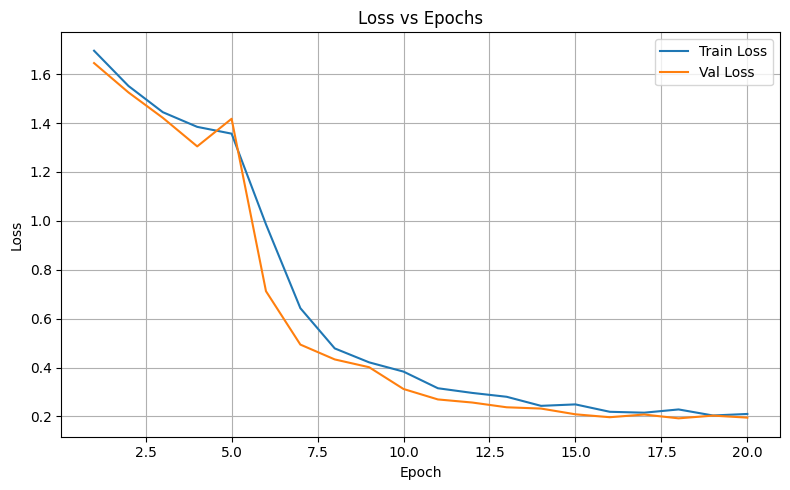

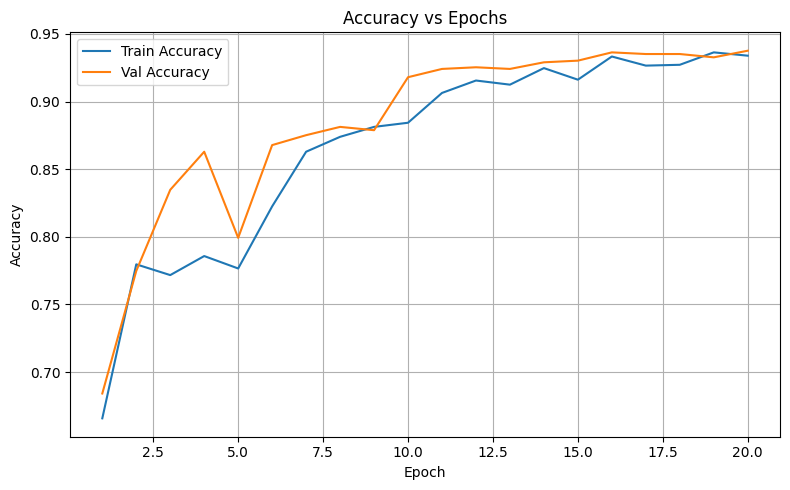

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load("best_mobilevit.pth", map_location=device))
model.eval()
print(" Best model loaded")

correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc = correct / total
print(f" Test Accuracy: {test_acc*100:.2f}%\n")

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


 Best model loaded
 Test Accuracy: 93.73%

 Classification Report:

              precision    recall  f1-score   support

    Vertical       0.86      0.86      0.86         7
 defect free       1.00      0.98      0.99       178
        hole       0.95      0.62      0.75        32
  horizontal       0.88      1.00      0.93         7
       lines       0.52      0.92      0.67        12
       stain       0.90      1.00      0.95        35

    accuracy                           0.94       271
   macro avg       0.85      0.90      0.86       271
weighted avg       0.95      0.94      0.94       271



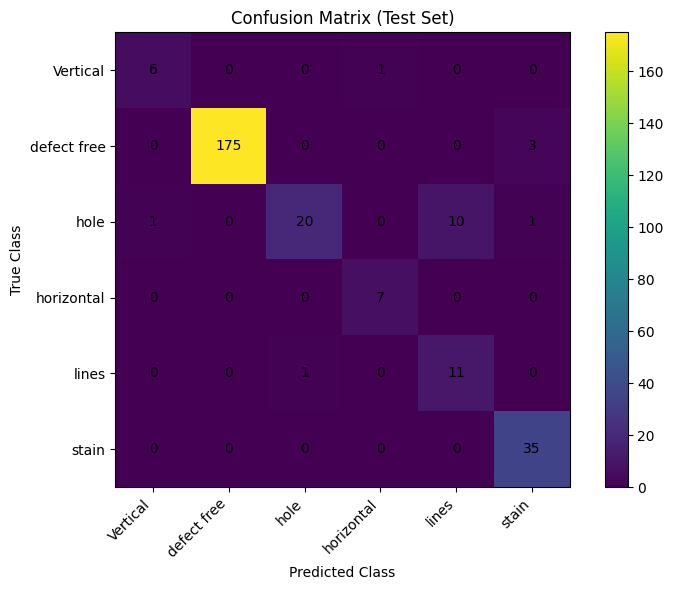

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
tick_marks = np.arange(len(class_names))

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


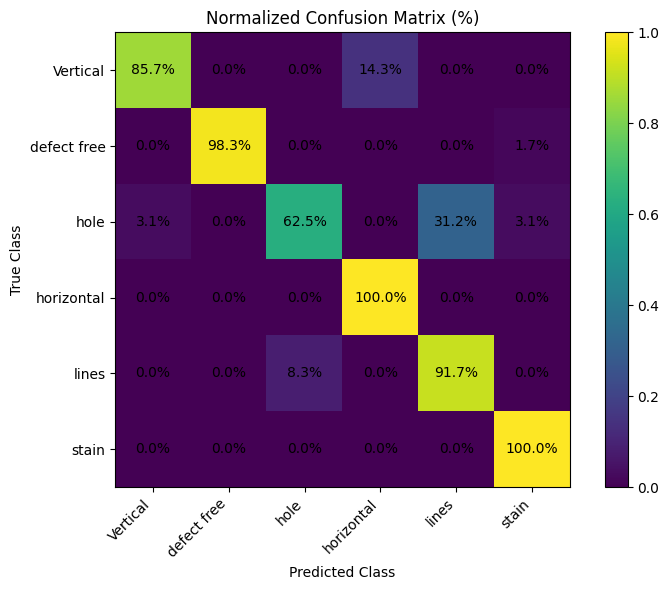

In [ ]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (%)")
plt.colorbar()
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha="center", va="center")

plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
from PIL import Image
import torch

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = Image.open(img_path).convert("RGB")
img_t = valid_tfms(img).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_t)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = probs.argmax(1).item()

pred_class = class_names[pred_idx]
confidence = probs[0, pred_idx].item()

print(f" Predicted: {pred_class} ({confidence*100:.2f}%)")


Saving stain.jpg to stain.jpg


NameError: name 'valid_tfms' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

# pick one index per class from test_ds
class_to_index = {name: i for i, name in enumerate(class_names)}
picked = {}

for idx in range(len(test_ds)):
    img, label = test_ds[idx]
    cls_name = class_names[label]
    if cls_name not in picked:
        picked[cls_name] = idx
    if len(picked) == len(class_names):
        break

print("Picked samples:", picked)

# display images + predictions
plt.figure(figsize=(14, 8))

for i, cls_name in enumerate(class_names):
    idx = picked[cls_name]
    img, true_label = test_ds[idx]

    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_input)
        probs = torch.softmax(out, dim=1)
        pred_idx = probs.argmax(1).item()
        conf = probs[0, pred_idx].item()

    pred_class = class_names[pred_idx]
    true_class = class_names[true_label]

    # convert tensor image for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * np.array([0.229, 0.224, 0.225]) +
              np.array([0.485, 0.456, 0.406]))  # unnormalize
    img_np = np.clip(img_np, 0, 1)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"True: {true_class}\nPred: {pred_class} ({conf*100:.1f}%)")

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined